# **Loading data and packages**

**Libraries import**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
from joblib import load, dump

from sklearn.model_selection import (
    train_test_split, LeaveOneOut, cross_validate, learning_curve, cross_val_predict
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    make_scorer, confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTENC, ADASYN
from imblearn.metrics import geometric_mean_score


**Data import**

In [2]:
# Defining global variables to store the DataFrame
df = pd.DataFrame()
dataset_name = None
X = None
y = None
balancing_method_selected = None

# Function to list CSV files in the directory
def list_csv_files(directory):
    return [f for f in os.listdir(directory) if f.endswith('.csv')]

# Function to load and process the selected dataset
def load_and_process_data(selected_file):
    global df, dataset_name, X, y
    dataset_name = selected_file
    file_path = os.path.join('..', 'datasets', 'feature_selection', dataset_name)

    if not os.path.exists(file_path):
        print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
        return None

    df = pd.read_csv(file_path)

    # Converting 'Gender' to numeric values
    if 'Gênero' in df.columns:
        df['Gênero'] = df['Gênero'].replace({'M': 0, 'F': 1})

    # Normalizing 'Age_clinic'
    if 'Idade_clinica' in df.columns:
        scaler = MinMaxScaler()
        df['Idade_clinica'] = scaler.fit_transform(df[['Idade_clinica']])

    # Defining X (features) and y (target)
    X = df.drop(columns=['PROVAVEL_HAM/TSP']) 
    y = df['PROVAVEL_HAM/TSP'] 

    print(f"Data Loaded and Processed Successfully! Dataset: {dataset_name}")
    return df.head()

# Function to define the selected balancing method
def set_balancing_method(method):
    global balancing_method_selected  
    balancing_method_selected = method  
    print(f"Método de balanceamento selecionado: {balancing_method_selected}")

# Function to apply the selected balancing method
def apply_balancing(X, y):
    global balancing_method_selected
    if balancing_method_selected is None:
        print("Nenhum método de balanceamento foi selecionado.")
        return X, y

    if balancing_method_selected == 'Random Over Sampler':
        balancer = RandomOverSampler()
    elif balancing_method_selected == 'SMOTENC':
        # Identify categorical columns
        categorical_features = [i for i, col in enumerate(X.columns) if col != 'Idade_clinica']
        balancer = SMOTENC(categorical_features=categorical_features, random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        balancer = RandomUnderSampler()
    elif balancing_method_selected == 'Tomek Links':
        balancer = TomekLinks()
    else:
        print(f"Método de balanceamento desconhecido: {balancing_method_selected}")
        return X, y

    # Applying the balancing method
    X_res, y_res = balancer.fit_resample(X, y)
    return X_res, y_res

# Define the directory where the CSV files are located
directory = '../datasets/feature_selection/'

# List the CSV files available in the directory
csv_files = list_csv_files(directory)

# Create a selection widget with the files listed
file_selector = widgets.Dropdown(
    options=csv_files,
    description='Select File:'
)

# Create a widget to select the balancing method
balancing_methods = ['Random Over Sampler', 'SMOTENC', 'Random Under Sampler', 'Tomek Links']
method_selector = widgets.Dropdown(
    options=balancing_methods,
    description='Balancing Method:'
)

# Interactive function to load and process the selected CSV file
@interact(selected_file=file_selector)
def load_and_process_selected_file(selected_file):
    return load_and_process_data(selected_file)

# Interactive function to apply the selected balancing method
@interact(selected_method=method_selector)
def apply_selected_balancing_method(selected_method):
    set_balancing_method(selected_method)
    X_res, y_res = apply_balancing(X, y)  # Aplica o balanceamento aos dados carregados
    print(f"Shape dos dados balanceados: {X_res.shape}, {y_res.shape}")

interactive(children=(Dropdown(description='Select File:', options=('cat2_df_clinic_ENTPD1.csv',), value='cat2…

interactive(children=(Dropdown(description='Balancing Method:', options=('Random Over Sampler', 'SMOTENC', 'Ra…

#  **Definition of variables, models and metrics**

**Define the variables (X and y) and classifiers** 

In [3]:
# List of model names that have been adjusted
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AB', 'LSVM']

# Directory where models and results are saved
model_dir = '..\\models\\'

# Dictionary to store loaded templates
classifiers = {}

# Function for loading templates
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Load the model
        model = load(model_path)

        
        if isinstance(model, SVC):
            model.probability = True

        # Add the model to the classifiers dictionary using the corresponding name
        classifiers[model_name] = model

        print(f'Model {model_name} loaded with sucess.')
    else:
        print(f'Model {model_name} not found.')

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

Model DT loaded with sucess.
Model GB loaded with sucess.
Model LR loaded with sucess.
Model MLP loaded with sucess.
Model NB loaded with sucess.
Model RF loaded with sucess.
Model SVM loaded with sucess.
Model KNN loaded with sucess.
Model AB loaded with sucess.
Model LSVM loaded with sucess.


# **Model evaluation**

Generation of the results

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score)
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

# List to store the results
results = []

# Define the Leave-One-Out strategy
loo = LeaveOneOut()

# Function to apply the selected balancing method
def get_balancing_method():
    global balancing_method_selected
    if balancing_method_selected == 'Random Over Sampler':
        return RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'SMOTENC':
        categorical_columns = [col for col in X.columns if col != 'Idade_clinica']
        categorical_features = [X.columns.get_loc(col) for col in categorical_columns]
        return SMOTENC(categorical_features=categorical_features, random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        return RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        return TomekLinks()
    else:
        print("No valid balancing method selected.")
        return None

# Iterating on the classifiers
for clf_name, clf in classifiers.items():
    balancing_method = get_balancing_method()
    if balancing_method is None:
        print(f"Error: No valid balancing method for the {clf_name} classifier. Skipping this classifier.")
        continue

    # Define the pipeline
    pipeline = Pipeline([
        ('balancing', balancing_method),
        ('classifier', clf)
    ])

    # Store metrics per iteration
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    gmean_scores = []

    # Perform Leave-One-Out manually
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Skip iteration if only one class in test set
        if len(np.unique(y_test)) < 2:
            continue

        # Train and predict
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        try:
            y_prob = pipeline.predict_proba(X_test)[:, 1]
        except AttributeError:
            if hasattr(clf, "decision_function"):
                y_prob = pipeline.decision_function(X_test)
                # Normalize
                y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
            else:
                y_prob = np.zeros_like(y_pred)

        # Add iteration metrics with zero_division handling
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
        recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
        roc_auc_scores.append(roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else np.nan)
        gmean_scores.append(geometric_mean_score(y_test, y_pred))

    # Calculate global metrics
    y_pred_global = cross_val_predict(pipeline, X, y, cv=loo)
    try:
        y_prob_global = cross_val_predict(pipeline, X, y, cv=loo, method='predict_proba')[:, 1]
    except AttributeError:
        if hasattr(clf, "decision_function"):
            y_prob_global = cross_val_predict(pipeline, X, y, cv=loo, method='decision_function')
            y_prob_global = (y_prob_global - y_prob_global.min()) / (y_prob_global.max() - y_prob_global.min())
        else:
            y_prob_global = np.zeros_like(y_pred_global)

    # Add metrics to the DataFrame with proper handling of edge cases
    results.append({
        'classifier': clf_name,
        'Accuracy': accuracy_score(y, y_pred_global),
        'Accuracy Std': np.std(accuracy_scores) if accuracy_scores else np.nan,
        'Precision': precision_score(y, y_pred_global, zero_division=0),
        'Precision Std': np.std(precision_scores) if precision_scores else np.nan,
        'Recall': recall_score(y, y_pred_global, zero_division=0),
        'Recall Std': np.std(recall_scores) if recall_scores else np.nan,
        'F1': f1_score(y, y_pred_global, zero_division=0),
        'F1 Std': np.std(f1_scores) if f1_scores else np.nan,
        'G-Mean': geometric_mean_score(y, y_pred_global),
        'G-Mean Std': np.std(gmean_scores) if gmean_scores else np.nan,    
        'ROC AUC': roc_auc_score(y, y_prob_global) if len(np.unique(y)) > 1 else np.nan,
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be r

  classifier  Accuracy  Accuracy Std  Precision  Precision Std    Recall  \
0         DT  0.765306           NaN   0.523810            NaN  0.458333   
1         GB  0.693878           NaN   0.431818            NaN  0.791667   
2         LR  0.653061           NaN   0.368421            NaN  0.583333   
3        MLP  0.744898           NaN   0.333333            NaN  0.041667   
4         NB  0.653061           NaN   0.291667            NaN  0.291667   
5         RF  0.602041           NaN   0.325581            NaN  0.583333   
6        SVM  0.785714           NaN   0.666667            NaN  0.250000   
7        KNN  0.744898           NaN   0.466667            NaN  0.291667   
8         AB  0.714286           NaN   0.447368            NaN  0.708333   
9       LSVM  0.673469           NaN   0.413043            NaN  0.791667   

   Recall Std        F1  F1 Std    G-Mean  G-Mean Std   ROC AUC  
0         NaN  0.488889     NaN  0.629600         NaN  0.408784  
1         NaN  0.558824     NaN

c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [6]:
output_directory = '../results'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# File path
output_file = os.path.join(output_directory, 'results_metrics.csv')

# Save the DataFrame in CSV format
results_df.to_csv(output_file, index=False)

# Display confirmation message
print(f"Results saved in: {output_file}")


Results saved in: ../results\results_metrics.csv


Heatmap plot

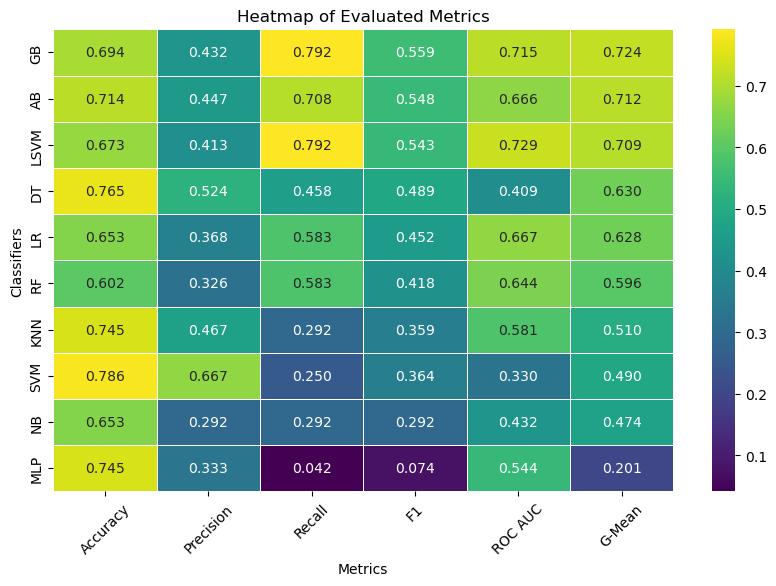

In [6]:
# Defining the names of the evaluation metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean']

# Selecting the metrics for the heatmap and configuring the index
heatmap_df = results_df[metric_names].set_index(results_df['classifier'])

# Sorting the DataFrame by G-Mean value
heatmap_df = heatmap_df.sort_values(by='G-Mean', ascending=False)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".3f", linewidths=.5)
plt.title('Heatmap of Evaluated Metrics')
plt.xlabel('Metrics')
plt.ylabel('Classifiers')
plt.xticks(rotation=45)
plt.savefig('../results/heatmap.jpeg')
plt.show()


Learning Curves

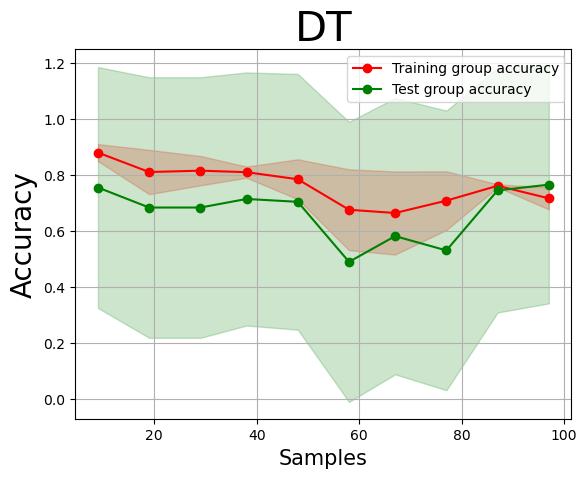

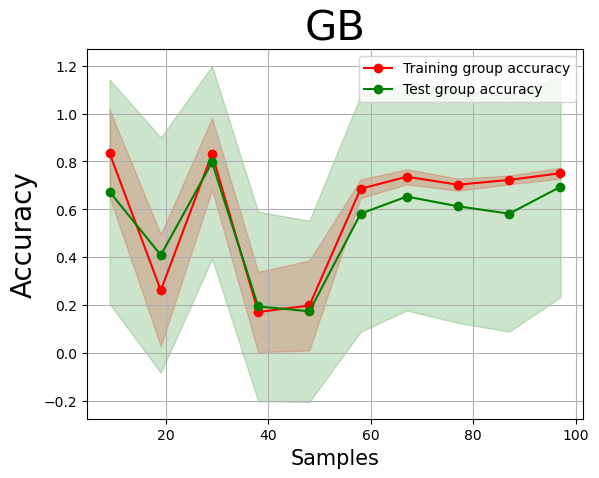

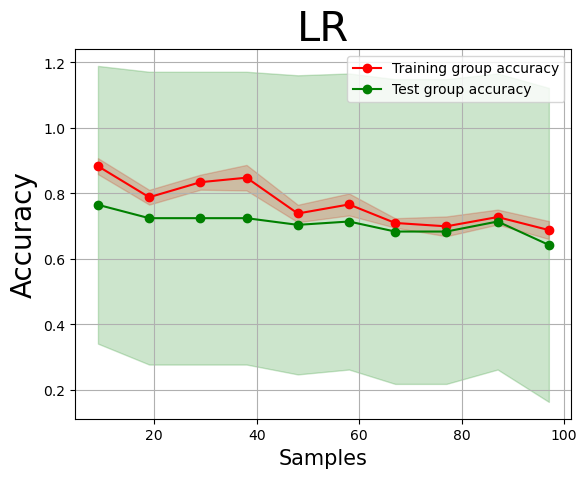

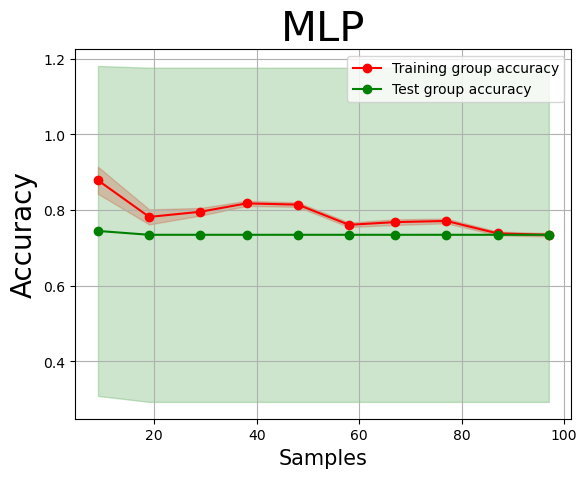

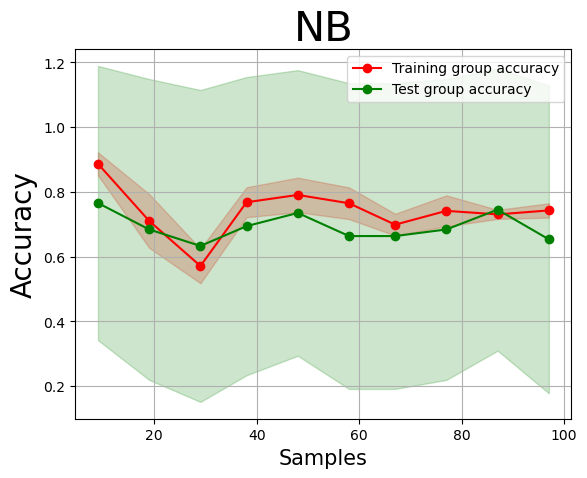

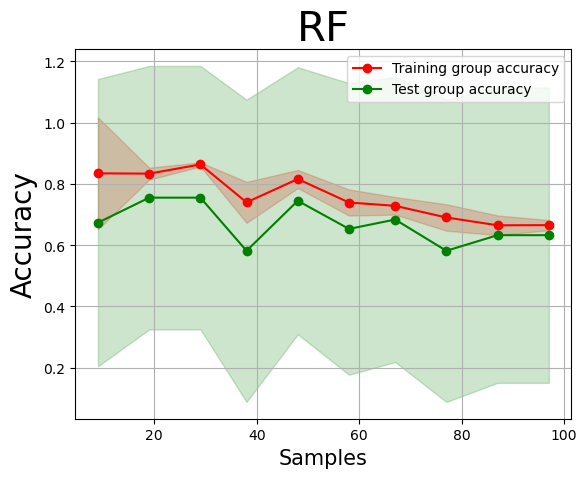

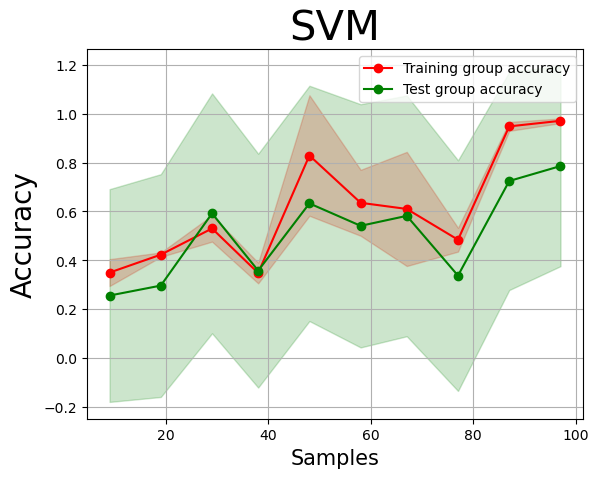

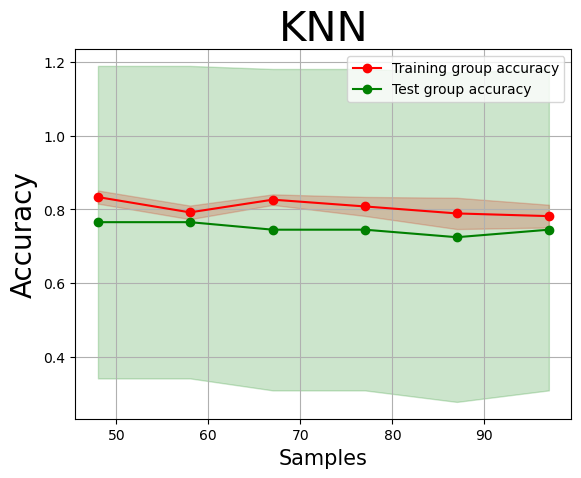

KeyboardInterrupt: 

In [4]:
loo = LeaveOneOut()

# Function to plot learning curves with shaded areas for standard deviation
def plot_learning_curve(X, y, classifiers, train_sizes=np.linspace(0.1, 1.0, 10)):
    results_dir = '..\\results\\'  # Adjust the directory path if needed
    for name, estimator in classifiers.items():
        # Get learning curve data
        train_sizes_abs, train_scores, test_scores = learning_curve(
            estimator, X, y, train_sizes=train_sizes, cv=loo, scoring='accuracy', n_jobs=-1
        )

        # Calculate means and standard deviations
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot the learning curves
        plt.figure()
        plt.title(f'{name}', fontsize = 30)
        plt.xlabel("Samples", fontsize = 15)
        plt.ylabel("Accuracy", fontsize = 20)

        # Plot training data and fill between for standard deviation
        plt.plot(train_sizes_abs, train_scores_mean, 'o-', label="Training group accuracy", color="r")
        plt.fill_between(train_sizes_abs, 
                         train_scores_mean - train_scores_std, 
                         train_scores_mean + train_scores_std, 
                         alpha=0.2, color="r")  # Shadow for training

        # Plot test data and fill between for standard deviation
        plt.plot(train_sizes_abs, test_scores_mean, 'o-', label="Test group accuracy", color="g")
        plt.fill_between(train_sizes_abs, 
                         test_scores_mean - test_scores_std, 
                         test_scores_mean + test_scores_std, 
                         alpha=0.2, color="g")  # Shadow for cross-validation

        # Show legend and grid
        plt.legend(loc="best")
        plt.grid(True)

        # Save the plot
        plot_filename = os.path.join(results_dir, f'curva_aprendizado_{name}.png')
        plt.savefig(plot_filename)
        plt.show()

# Example usage: Call the plot_learning_curve function with your data
plot_learning_curve(X, y, classifiers)

Confusion matrix

Model DT loaded with sucess.
Model GB loaded with sucess.
Model LR loaded with sucess.
Model MLP loaded with sucess.
Model NB loaded with sucess.
Model RF loaded with sucess.
Model SVM loaded with sucess.
Model KNN loaded with sucess.
Model AB loaded with sucess.
Model LSVM loaded with sucess.


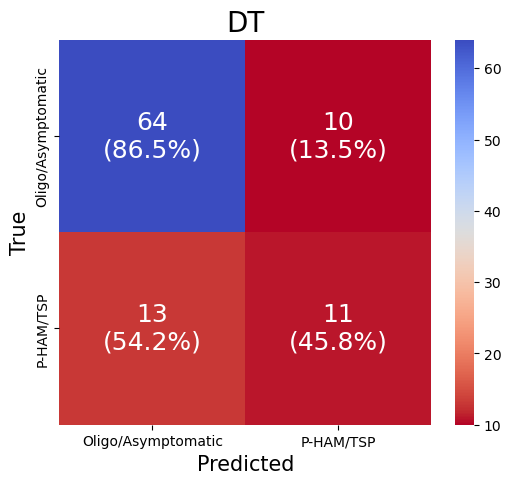

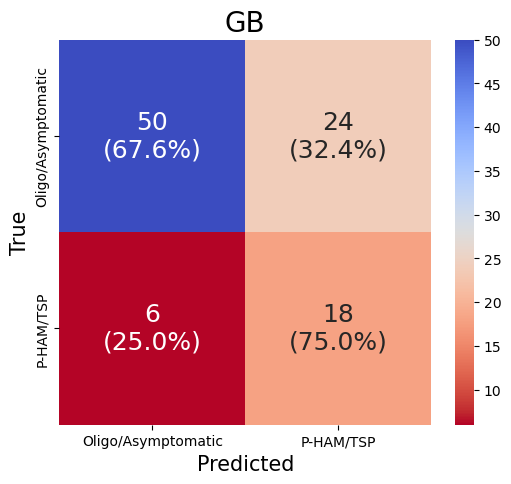

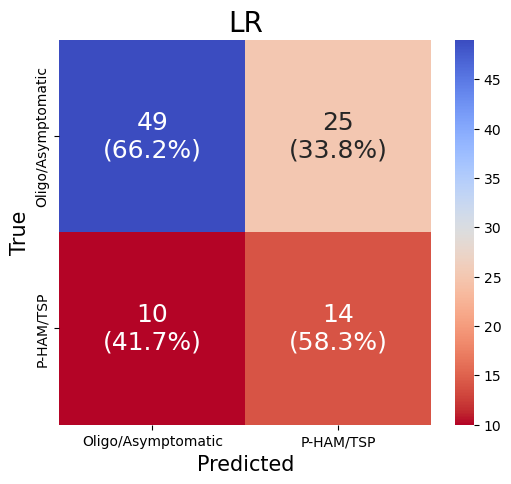

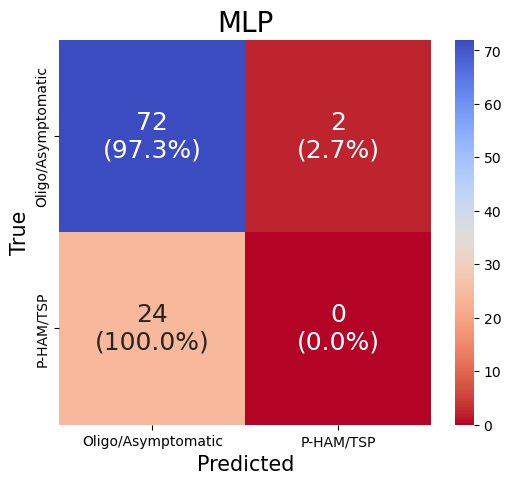

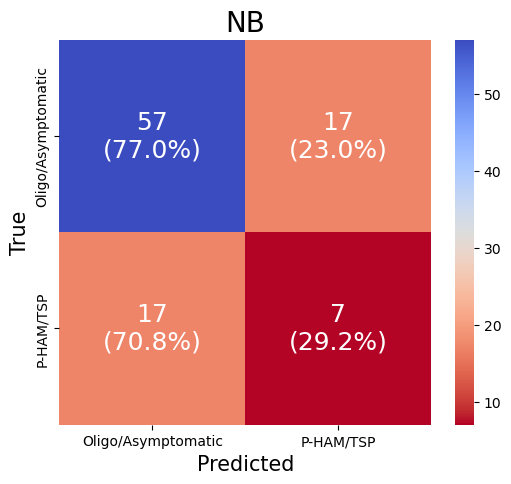

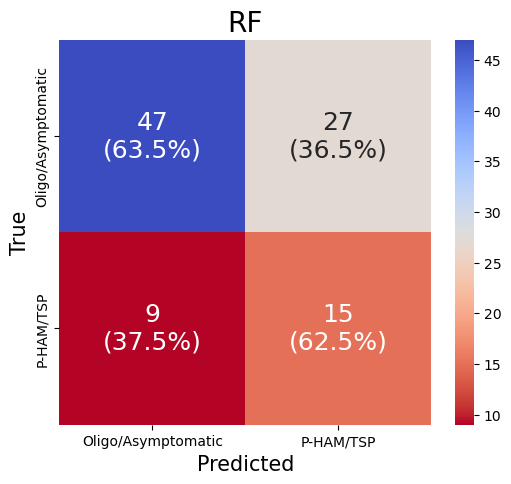

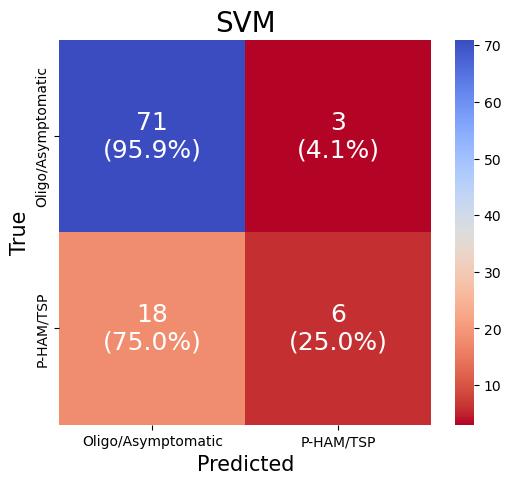

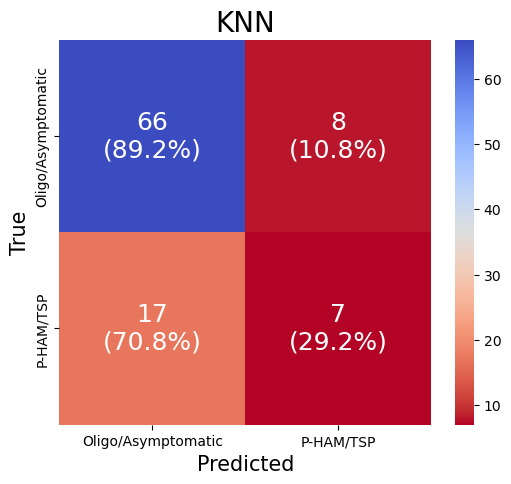

c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be r

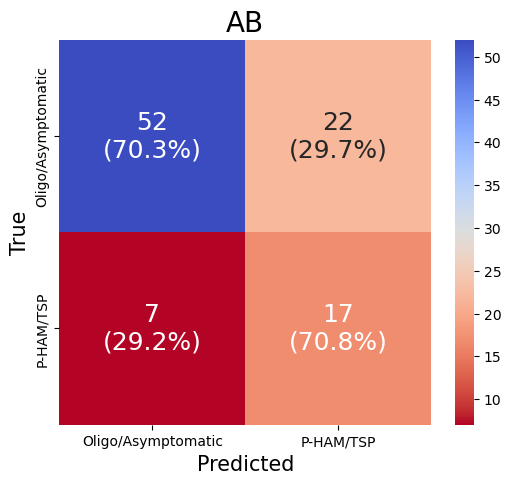

c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_classes.py

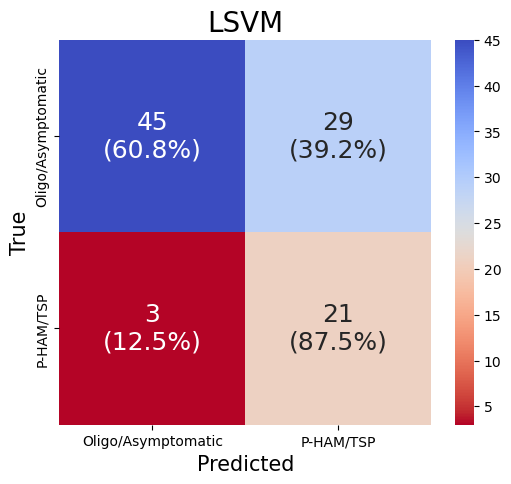

{'DT': Pipeline(steps=[('normalization', MinMaxScaler()),
                ('balancing', RandomUnderSampler(random_state=42)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.08123959883573634,
                                        max_depth=4, min_samples_leaf=4,
                                        min_samples_split=8,
                                        random_state=42))]), 'GB': Pipeline(steps=[('normalization', MinMaxScaler()),
                ('balancing', RandomUnderSampler(random_state=42)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.06610098295419149,
                                            max_depth=9, min_samples_leaf=7,
                                            min_samples_split=14,
                                            n_estimators=236, random_state=42,
                                            subsample=0.6376918441602301))]), 'LR': Pipeline(steps=[('normalization', Mi

In [10]:
loo = LeaveOneOut()
7# Function to plot confusion matrix with percentages per row
def plot_confusion_matrix(model_name, X, y, loo):
    model = classifiers[model_name]
    
    # Making predictions using cross_val_predict
    y_preds = cross_val_predict(model, X, y, cv=loo)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y, y_preds)
    
    # Convert confusion matrix to percentages per row
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percent = np.nan_to_num(cm_percent)  # Handle divisions by zero
    
    # Define custom labels
    labels = ['Oligo/Asymptomatic', 'P-HAM/TSP']

    # Create annotations combining absolute values and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

    # Plot the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=annot, fmt='', cmap='coolwarm_r',
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 18})  # Aumenta o tamanho das anotações
    plt.xlabel('Predicted', fontsize=15)
    plt.ylabel('True', fontsize=15)
    plt.title(f'{model_name}', fontsize=20)

    
    # Save the picture
    plt.savefig(f'../results/{model_name}_confusion_matrix.jpeg')
    plt.show()

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

# Plot the confusion matrix for each loaded model
for model_name in model_names:
    if model_name in classifiers:  # Only plot if the model is loaded successfully
        plot_confusion_matrix(model_name, X, y, loo)

# Print classifiers to verify model loading
print(classifiers)
